#  <span style='color:DarkBlue'>P7 - Implémentez un modèle de scoring</span>

<div style="text-align:center">
    <img src="images/logo_proj7_credit.png" width="50%">
</div>

 # <span class='bg-primary'>P7_07 - MLFlow</span>

Ce notebook traite de l'uasge du serveur **MLFlow UI** permettant la visualisation du tracking des expérimentations et le stockage centralisé des modèles avec également la vérification et detcection potentielle de Data Drifts avec
la librairie **Evidently**.

## <span style='background: PowderBlue'>1. Introduction</span>

In [232]:
import os
import numpy as np
import pandas as pd

import mlflow
from mlflow.tracking import MlflowClient
import mlflow.sklearn # Wrapper pour scikit-learn
import mlflow.lightgbm
import pickle
import fonctions_data
from pprint import pprint

# Métriques
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, average_precision_score, f1_score, \
    fbeta_score, make_scorer, confusion_matrix, recall_score, precision_score, log_loss, \
     classification_report, precision_recall_curve, PrecisionRecallDisplay

from sklearn.model_selection import cross_validate, RandomizedSearchCV, \
    GridSearchCV, learning_curve  # , cross_val_score

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import mlflow
from mlflow.tracking import MlflowClient
import shap
import joblib
from mlflow.models.signature import infer_signature

from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset
from evidently.tests import *

## <span style='background: PowderBlue'>2. Chargement des datasets nettoyés</span>

#### <span style='background:mistyrose'>**Chargement du jeu de données du train set issu du pré-processing et de la feature sélection**</span>

In [206]:
fic_sav_train_set = \
    'pickle_files/train_set.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 218)

#### <span style='background:mistyrose'>**Chargement du jeu de données du test set issu du pré-processing et de la feature sélection**</span>

In [208]:
fic_sav_test_set = \
    'pickle_files/test_set.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 217)

## <span style='background: PowderBlue'>3. Préparation du dataset</span>

In [210]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21
print(f'Nombre aléatoire : {seed}')

Nombre aléatoire : 21


### <span style='background:orange'>3.1. Split du jeu d'entraînement en entraînement/validation</span>

**Vecteur y**

In [212]:
# Vecteur y cible
y = train_set['TARGET']
print(f'y : {y.shape}')

y : (307507,)


**Matrice X**

In [214]:
# Matrice X
# Copie du jeu de données
train_set = train_set.copy(deep=True)
# Passage de l'identifiant du client en index pour la modélisation
#train_set.set_index('SK_ID_CURR', inplace=True)
#X = train_set 
# Suppression de la variable cible pour la modélisation
X = train_set.drop(['TARGET'], axis=1)
print(f'X : {X.shape}')

X : (307507, 217)


**Découpage du jeu d'entraînement**

In [272]:
# Découpage du jeu d'entraînement en :
# X_train : pour entraîner le modèle et trouver les meilleurs
#           hyperparamètres
# X_valid : pour évaluer les performances du modèle
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      stratify=y,
                                                      random_state=seed)
print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_test : {X_test.shape} - y_test : {y_test.shape}')

X_train : (246005, 217) - y_train : (246005,)
X_test : (61502, 217) - y_test : (61502,)


In [218]:
# Métriques
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                      needs_proba=True)
pr_auc = make_scorer(average_precision_score, greater_is_better=True,
                     needs_proba=True)
f1_score = make_scorer(fbeta_score, beta=1, greater_is_better=True)
f5_score = make_scorer(fbeta_score, beta=5, greater_is_better=True)
f10_score = make_scorer(fbeta_score, beta=10, greater_is_better=True)
custom_score = make_scorer(fonctions_data.custom_score,
                           greater_is_better=True)
custom_score_2 = make_scorer(fonctions_data.custom_score_2,
                           greater_is_better=True)
custom_score_3 = make_scorer(fonctions_data.custom_score_3,
                           greater_is_better=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## <span style='background: PowderBlue'>4. Fonctions d'évaluation</span>

Ces focntions d'évalution via l'entrainement des différents modèles et visualisation du crière AUC, et du score métier permettront de sélectionner le meilleur modèle pour 
le tracking d'experimentations (**MLFlow UI**)

In [220]:
def roc_auc(y_true, y_pred_proba):
    """Trace la courbe ROC et calcule le score ROC AUC"""
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color='red', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

In [222]:
def fonction_metier(y_true, y_pred):
    """Création d'un score métier : minimisation du coût d’erreur de prédiction des FN et FP (pondération 10 contre 1)"""
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sm = (10*fn+fp)
    return sm

In [224]:
def evaluation(model, titre):
    """Evaluation d'un modèle affichant :
        - la matrice de confusion
        - le score métier
        - la courbe ROC avec le score ROC AUC"""
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    

    fonctions_data.afficher_matrice_confusion(y_test, y_pred, titre)

    # Métrique métier
    banque_score = fonction_metier(y_test, y_pred)
    print("\nScore métier =", banque_score, "\n(Le meilleur est le plus bas)")
    print("\n________________\nRapport de classification")
    print(classification_report(y_test, y_pred))
    roc_auc(y_test, y_pred_proba)
    return banque_score

## <span style='background: PowderBlue'>5. Modélisation</span>

### <span style='background:orange'>5.1. DummyClassifier</span>

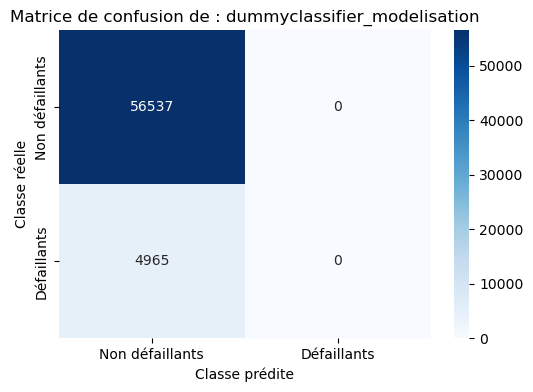


Score métier = 49650 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502



C:\Users\yanni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yanni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yanni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


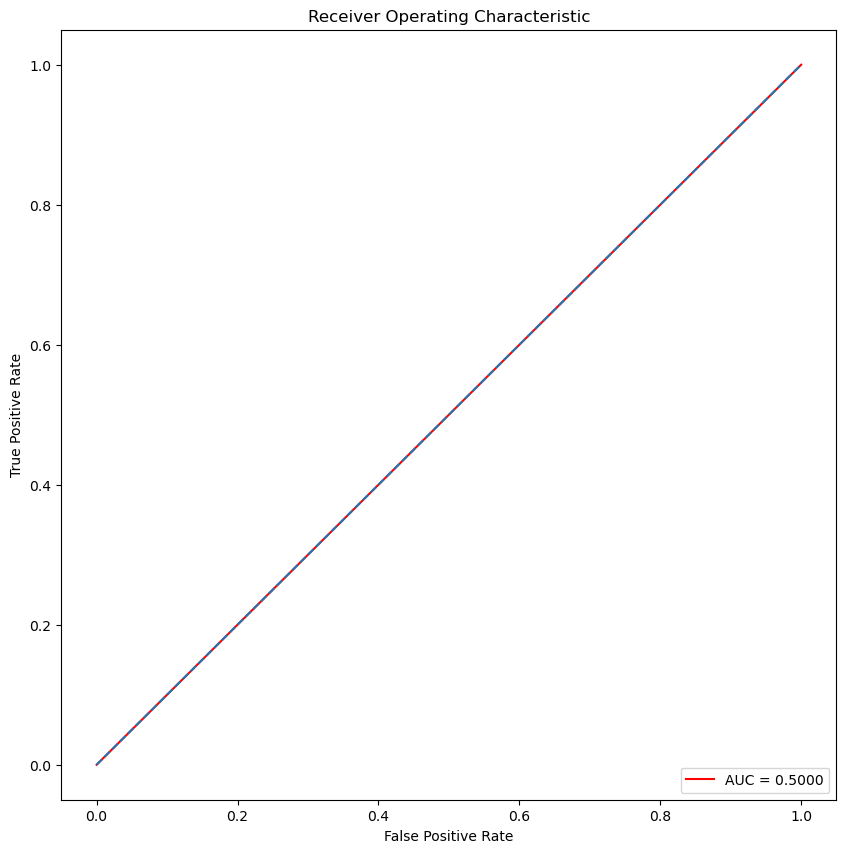

49650

In [226]:
estimator = DummyClassifier(strategy='most_frequent')
evaluation(estimator, 'dummyclassifier_modelisation')

### <span style='background:orange'>5.2. Modèles à tester</span>

In [228]:
preprocessor = make_pipeline(SimpleImputer(missing_values = np.nan, strategy='median'),
                             SelectKBest(f_classif, k='all'))

In [234]:
RandomForest = make_pipeline(preprocessor,
                             RandomForestClassifier(class_weight='balanced',
                                                    random_state=39,
                                                    n_jobs=-1))

LogisticRegression = make_pipeline(preprocessor,
                                   StandardScaler(),
                                   LogisticRegression(class_weight='balanced',
                                                      random_state=39,
                                                      n_jobs=-1))

XGBoost = make_pipeline(preprocessor,
                        XGBClassifier(scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
                                      random_state=39,
                                      n_jobs=-1))

LightGBM = make_pipeline(preprocessor,
                         LGBMClassifier(class_weight='balanced',
                                        random_state=39,
                                        n_jobs=-1))

In [236]:
dict_of_models = {'RandomForest': RandomForest,
                  'LogisticRegression': LogisticRegression,
                  'XGBoost': XGBoost,
                  'LightGBM': LightGBM
                 }

----------------------------------------------------------------------

Modèle : RandomForest


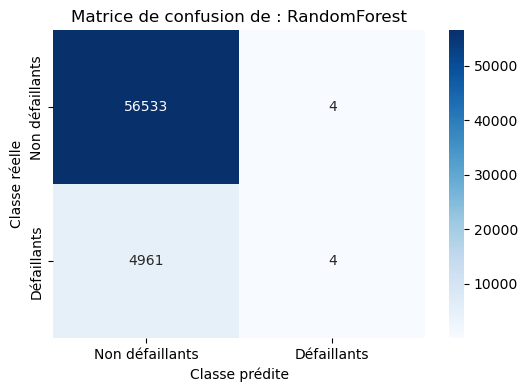


Score métier = 49614 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.50      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.50      0.48     61502
weighted avg       0.89      0.92      0.88     61502



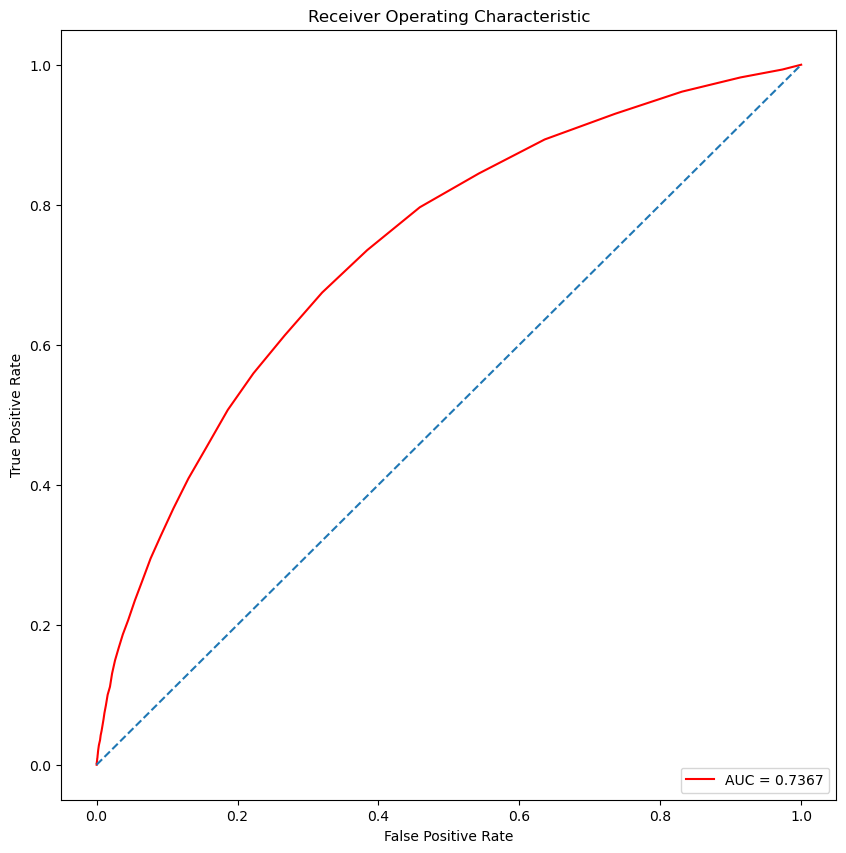

----------------------------------------------------------------------

Modèle : LogisticRegression


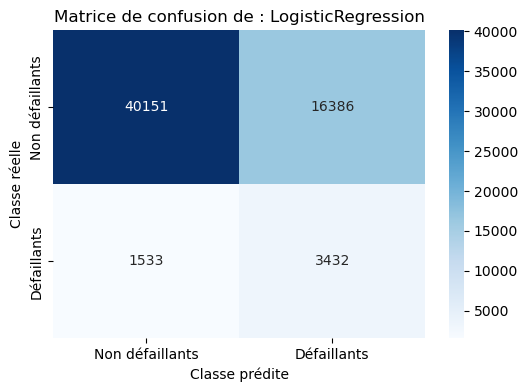


Score métier = 31716 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56537
           1       0.17      0.69      0.28      4965

    accuracy                           0.71     61502
   macro avg       0.57      0.70      0.55     61502
weighted avg       0.90      0.71      0.77     61502



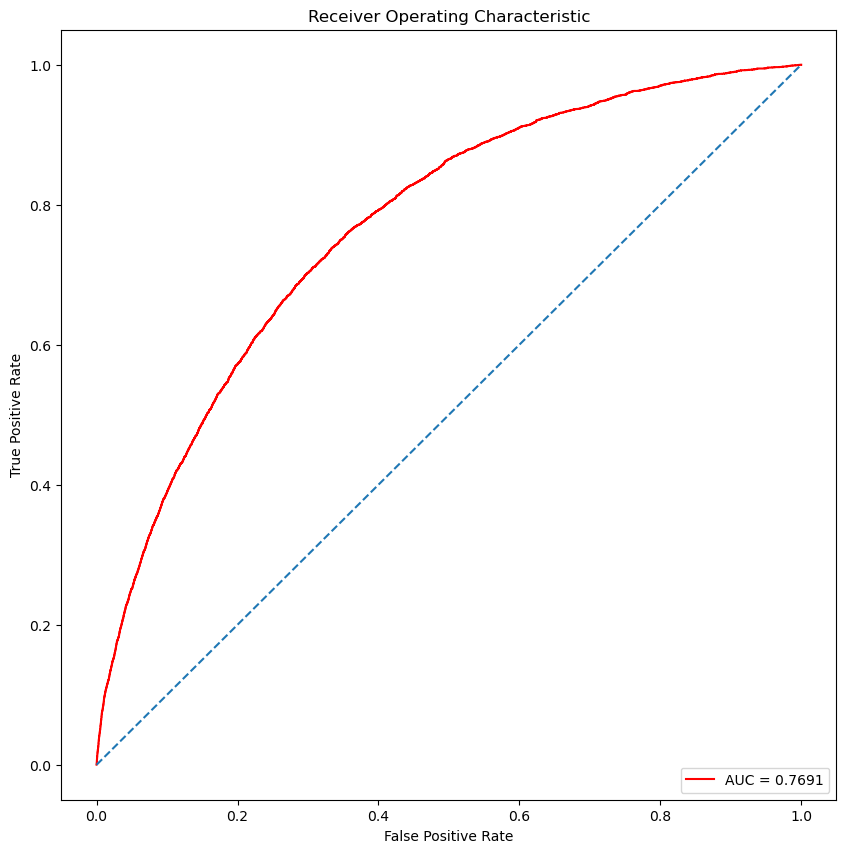

----------------------------------------------------------------------

Modèle : XGBoost


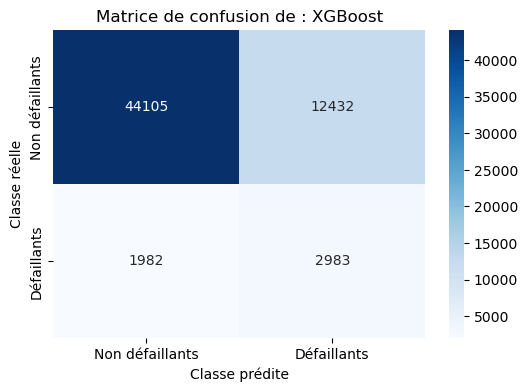


Score métier = 32252 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     56537
           1       0.19      0.60      0.29      4965

    accuracy                           0.77     61502
   macro avg       0.58      0.69      0.58     61502
weighted avg       0.90      0.77      0.81     61502



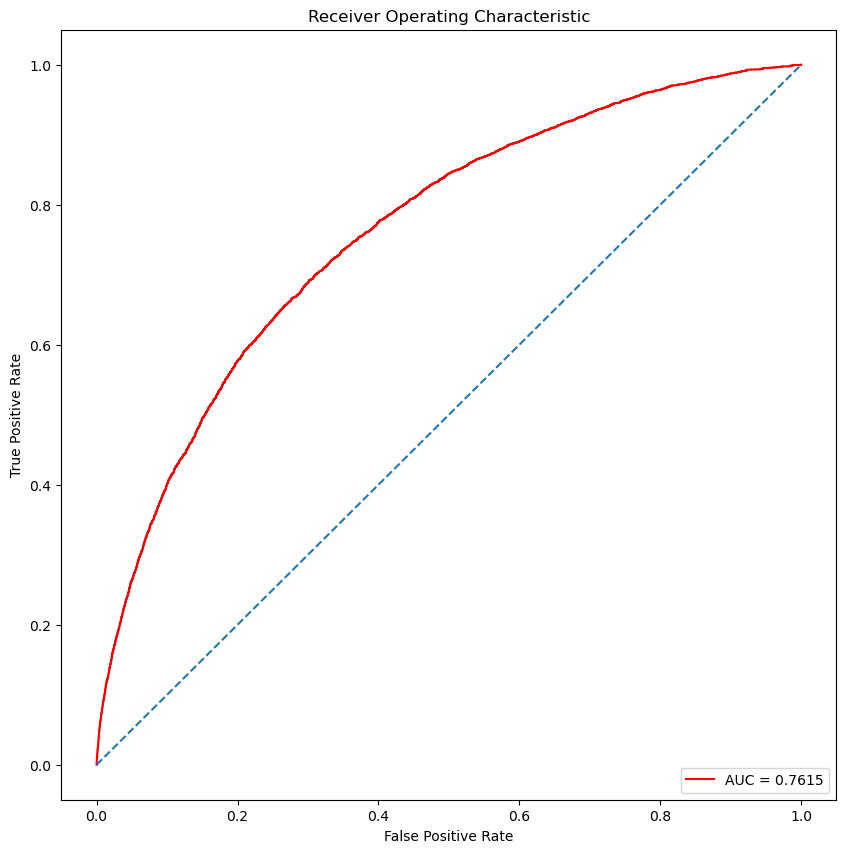

----------------------------------------------------------------------

Modèle : LightGBM
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.370762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36248
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


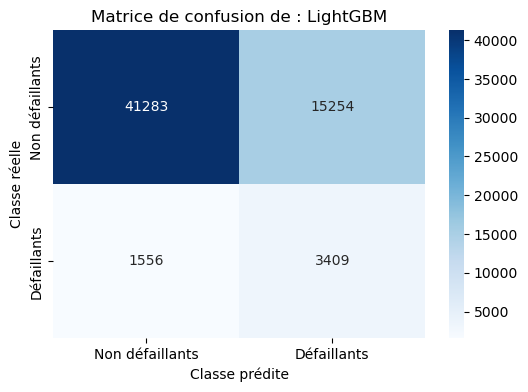


Score métier = 30814 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56537
           1       0.18      0.69      0.29      4965

    accuracy                           0.73     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.73      0.79     61502



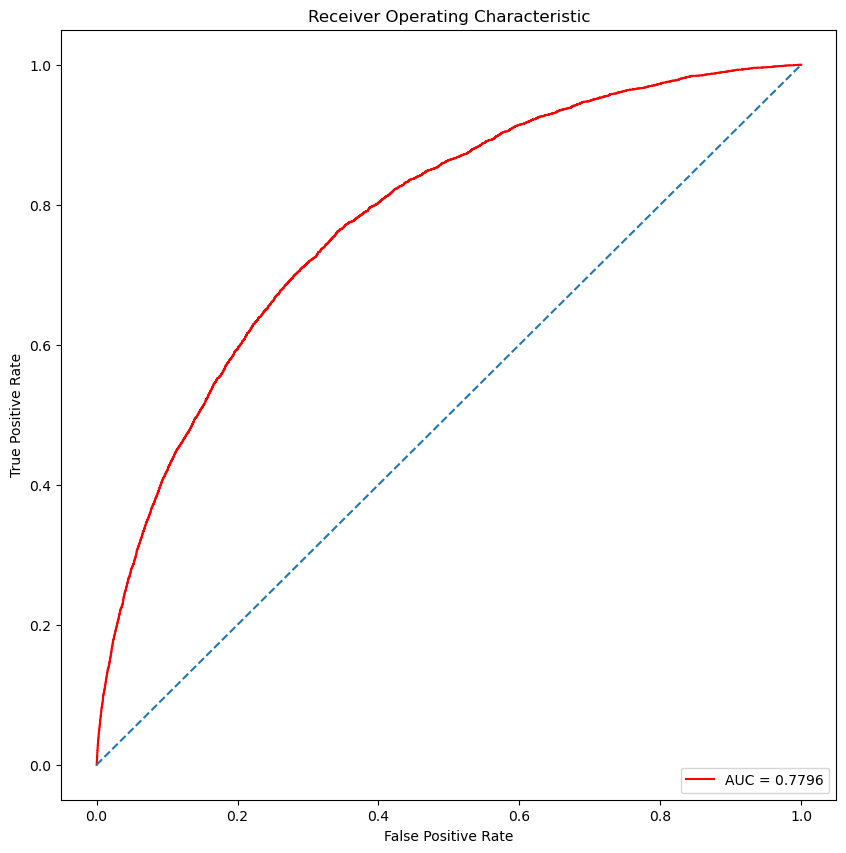

In [131]:
for name, model in dict_of_models.items():
    #with timer("Modèle - fit, predict, scores"):
        print('-'*70)
        print('\nModèle :', name)
        evaluation(model, name)

Actuellement, les **meilleurs résultats** sont apportés par **LightGBM**, en termes d'AUC.

Mais, il est possible d'améliorer tous les modèles.

### <span style='background:orange'>5.3. Optimisation de l'algorithme LGBMClassifier</span>

- Nous utilisons une grille de recherche avec validation croisée (GridSearchCV) pour l’optimisation des hyperparamètres.
- Pour la cross validation, l’utilisation de StratifiedKFold permet de prendre en compte la distribution de la target et de construire des folds avec une distribution de classe représentative de la distribution dans le jeu de données d’entraînement complet.
- Pour l’évaluation, nous mettons en place un score métier adapté à la problématique, le F-beta score avec beta=2 (cf. note méthodologique partie “Fonction de coût”) pour comparer les modèles, choisir le meilleur modèle et les meilleurs hyperparamètres associés. En parallèle nous maintenons également pour comparaison et contrôle des métriques techniques telles que l’AUC (Area Under the Receiver Operating Characteristic Curve) et l’accuracy (fraction de prédictions correctes).
- Un tracking des expériences avec **MLFlow** est réalisé par la suite.

In [238]:
##########################
# FONCTIONS MLFlow       #
#########################
# ML FLOW
def fetch_logged_data(run_id):
    client = MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

In [240]:
#experiment_id = mlflow.create_experiment("New modèle final")
# Initialiser MLFlow et définir l'expérience
mlflow.set_experiment("Credit Scoring")

<Experiment: artifact_location='file:///C:/Users/yanni/OneDrive/Bureau/P7_Modelisation_risque_defaut_credit/mlruns/695154182802122407', creation_time=1720735004441, experiment_id='695154182802122407', last_update_time=1720735004441, lifecycle_stage='active', name='Credit Scoring', tags={}>

### Métrique évaluation du modèle
Nous allons créer une fonction de coût qui permet la minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.

On suppose, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP. On utilise le F-Beta Score avec beta = 2 afin de donner une importance plus grande au rappel.

En parallèle, on maintient, pour comparaison et contrôle, des mesures plus techniques, telles que l’AUC et l’accuracy.

In [242]:
# Définition des métriques de performance
scoring = {
    'fbeta_score': make_scorer(fbeta_score, beta=2),
    'auc_score': make_scorer(roc_auc_score),
    'accuracy': make_scorer(accuracy_score)
}

### Grille de Recherche avec Validation croisée

In [244]:
# enable autologging
mlflow.set_experiment("experiment_blent")
mlflow.lightgbm.autolog()

print("Starting LightGBM. Train shape: {}, test shape: {}".format(X_train.shape, X_test.shape))
#Initialisation du classifieur
lgbm=LGBMClassifier(random_state=42)
# Paramètres de la grille de recherche
lgbm_parameters_grid = { 'n_estimators': [200, 500,1000],
                        'learning_rate': [0.02,0.1,0.5],
                        'max_depth' : [3,5,8],
                       }

# Initialisation de la grille de recherhce
lgbm_grid_search = GridSearchCV(estimator=lgbm, 
                              param_grid=lgbm_parameters_grid,
                              scoring=scoring,
                              refit='fbeta_score',                              
                              cv= 5,
                              n_jobs=10,
                              verbose=True)

2024/07/14 11:53:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.


Starting LightGBM. Train shape: (246005, 217), test shape: (61502, 217)


In [246]:
with mlflow.start_run() as run:
    lgbm_grid_search.fit(X_train, y_train)

2024/07/14 11:54:02 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Fitting 5 folds for each of 27 candidates, totalling 135 fits


2024/07/14 12:45:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\yanni\anaconda3\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.326230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36224
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469


2024/07/14 12:45:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\yanni\anaconda3\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [248]:
# fetch logged data
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

pprint(params)
pprint(metrics)
pprint(tags)
pprint(artifacts)

{'boosting_type': 'gbdt',
 'categorical_feature': 'auto',
 'colsample_bytree': '1.0',
 'feature_name': 'auto',
 'keep_training_booster': 'False',
 'learning_rate': '0.5',
 'max_depth': '8',
 'metric': "['binary']",
 'min_child_samples': '20',
 'min_child_weight': '0.001',
 'min_split_gain': '0.0',
 'num_boost_round': '500',
 'num_leaves': '31',
 'num_threads': '4',
 'objective': 'binary',
 'random_state': '42',
 'reg_alpha': '0.0',
 'reg_lambda': '0.0',
 'subsample': '1.0',
 'subsample_for_bin': '200000',
 'subsample_freq': '0'}
{}
{}
['model/MLmodel',
 'model/conda.yaml',
 'model/model.pkl',
 'model/python_env.yaml',
 'model/requirements.txt']


### Meilleurs scores et hyperparamètres

In [250]:
print(lgbm_grid_search.best_score_, lgbm_grid_search.best_params_) # Affichez le meilleur score  et les meilleurs hyperparamètres.
lgbm_grid_search.best_estimator_.score(X_test, y_test) # prédiction sur la base de test avec à partir du modèle entraîné

0.12376872201326736 {'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 500}


0.9041006796526943

In [252]:
lgbm_grid_results = pd.DataFrame(lgbm_grid_search.cv_results_)
lgbm_grid_results 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_fbeta_score,split1_test_fbeta_score,...,std_test_auc_score,rank_test_auc_score,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,141.941292,47.975754,1.868510,1.121248,0.02,3,200,"{'learning_rate': 0.02, 'max_depth': 3, 'n_est...",0.000315,0.000629,...,0.000056,27,0.919270,0.919270,0.919290,0.919290,0.919270,0.919278,0.000010,15
1,256.058714,15.891262,2.736688,1.188462,0.02,3,500,"{'learning_rate': 0.02, 'max_depth': 3, 'n_est...",0.011287,0.014097,...,0.000587,24,0.919534,0.919615,0.919839,0.919554,0.919270,0.919563,0.000182,9
2,278.341003,28.779450,4.942530,3.438632,0.02,3,1000,"{'learning_rate': 0.02, 'max_depth': 3, 'n_est...",0.027748,0.027101,...,0.000956,23,0.919859,0.919494,0.919859,0.919494,0.919209,0.919583,0.000248,8
3,153.724099,18.119610,2.591972,2.203165,0.02,5,200,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.004400,0.007223,...,0.000430,26,0.919392,0.919514,0.919494,0.919473,0.919270,0.919428,0.000089,12
4,245.046293,27.960661,1.915411,0.146365,0.02,5,500,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.032700,0.025866,...,0.001719,22,0.920144,0.919473,0.920042,0.919412,0.919615,0.919737,0.000300,5
5,395.509878,35.386896,3.183362,0.721254,0.02,5,1000,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.046743,0.046414,...,0.001190,19,0.920042,0.919859,0.919981,0.919778,0.919778,0.919888,0.000107,1
6,128.026205,15.623317,1.130318,0.138705,0.02,8,200,"{'learning_rate': 0.02, 'max_depth': 8, 'n_est...",0.006906,0.008472,...,0.000258,25,0.919351,0.919433,0.919554,0.919595,0.919331,0.919453,0.000106,10
7,264.880860,34.843702,3.061536,2.093781,0.02,8,500,"{'learning_rate': 0.02, 'max_depth': 8, 'n_est...",0.036947,0.033261,...,0.001587,20,0.919717,0.919615,0.919981,0.919656,0.919839,0.919762,0.000133,3
8,614.928212,13.515050,4.120766,1.245564,0.02,8,1000,"{'learning_rate': 0.02, 'max_depth': 8, 'n_est...",0.048835,0.047330,...,0.000892,17,0.919819,0.919900,0.919737,0.920002,0.919717,0.919835,0.000106,2
9,46.122895,7.058951,0.735768,0.103275,0.1,3,200,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.032067,0.029243,...,0.001588,21,0.919961,0.919351,0.920042,0.919351,0.919514,0.919644,0.000299,6


In [254]:
output = {
     'Accuracy': accuracy_score(y_test, lgbm_grid_search.predict(X_test)),
     'AUC': roc_auc_score(y_test, lgbm_grid_search.predict_proba(X_test)[:,1]),
     'fbeta_score': fbeta_score(y_test, lgbm_grid_search.predict(X_test), beta=2),
     'mean fit time' : lgbm_grid_results.loc[lgbm_grid_results['rank_test_accuracy']==1,'mean_fit_time'].values[0]

 }
output

2024/07/14 12:47:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\yanni\anaconda3\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/14 12:47:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\yanni\anaconda3\Lib\site-packages\mlflow\types

{'Accuracy': 0.9041006796526943,
 'AUC': 0.7238698766918957,
 'fbeta_score': 0.11952191235059761,
 'mean fit time': 395.5098783493042}

In [256]:
# Chargement du modèle MLflow
model = pickle.load(open(".\\mlruns\\968964749954438347/6e7635adf94c4fd79c6369a05600d325\\artifacts\\model\\model.pkl", "rb"))
model

C:\Users\yanni\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


LGBMClassifier(learning_rate=0.5, max_depth=8, n_estimators=500, n_jobs=-1,
               random_state=42)

In [274]:
X_test.shape

(61502, 217)

In [276]:
X_test

,SK_ID_CURR,CREDIT_TO_ANNUITY_RATIO,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,INSTAL_AMT_PAYMENT_DIFF_MIN,POS_CNT_INSTALMENT_MIN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_DAYS_FIRST_DRAWING_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,PREV_APPLICATION_AMT_TO_DECISION_RATIO_MIN,...,PREV_NAME_YIELD_GROUP_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,POS_LOAN_COMPLETED_MEAN,PREV_AMT_DECLINED_SUM,INSTAL_AMT_INSTALMENT_MIN,INSTAL_AMT_PAYMENT_RATIO_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,PREV_LOAN_RATE_MEAN,PREV_DAYS_DECISION_MEAN,EXT_SOURCE_2
189031,319159,0.5040,0.03705,0.000000,0.0,9.0,0.0000,365243.0,4560.811,17.154102,...,3.250,0.2708,0.0961,-119479.5,3225.825,1.000000,0.0000,0.07590,-1362.0,0.5660
202940,335264,0.3394,0.00000,0.000000,0.0,12.0,0.0000,365243.0,4560.811,33.523224,...,2.500,0.2708,0.0769,-98401.5,3903.930,0.974359,0.4944,0.07294,-971.5,0.3054
294802,441537,0.6160,0.00000,0.000000,0.0,12.0,0.0000,365243.0,4560.811,65.343660,...,3.500,0.2708,0.1295,-50490.0,16274.790,0.935484,0.4944,0.08575,-1498.0,0.7876
242182,380384,0.1220,0.03705,0.000000,0.0,4.0,0.2500,365243.0,4560.811,16.726883,...,3.750,0.2708,0.7180,17811.0,4962.060,0.952381,0.4944,0.14260,-803.0,0.4550
88284,202501,0.3100,0.00000,0.000000,0.0,8.0,0.0000,365243.0,4560.811,0.000000,...,1.500,0.2708,0.1000,-122890.5,4743.450,1.000000,0.4944,0.08440,-560.0,0.6475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273188,416672,0.2880,0.00000,0.003832,0.0,6.0,0.0000,365243.0,4560.811,0.000000,...,1.625,0.2708,0.2197,-200178.0,3640.410,0.963636,0.4944,0.08300,-933.0,0.5070
273100,416580,0.6113,0.00000,0.000000,0.0,6.0,0.0000,365243.0,4560.811,40.994260,...,3.000,0.2708,0.1428,11340.0,8697.690,0.545455,0.4944,0.19010,-1393.0,0.8260
144457,267507,0.3884,0.00000,0.000000,-675360.0,4.0,0.0000,365243.0,4560.811,32.330180,...,3.000,0.2708,0.3096,-91912.5,3416.085,2.217283,0.4944,0.08620,-1216.0,0.5215
234129,371208,0.4592,0.00000,0.000000,0.0,4.0,0.0000,365243.0,4560.811,63.975710,...,3.000,0.2708,0.3000,2835.0,9820.305,1.000000,0.4944,0.19190,-844.0,0.6255


In [280]:
feats = [f for f in X_test.columns if f not in ['TARGET']]
lgbm_grid_search.best_estimator_.score(X_test[feats], y_test)
y_predictions= lgbm_grid_search.predict_proba(X_test[feats])

2024/07/14 12:51:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\yanni\anaconda3\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [282]:
my_lgbm_classif= LGBMClassifier(**lgbm_grid_search.best_params_)
my_lgbm_classif

LGBMClassifier(learning_rate=0.5, max_depth=8, n_estimators=500)

In [284]:
run_id = mlflow.last_active_run().info.run_id
print("Logged data and model in run {}".format(run_id))

Logged data and model in run 1458528b04bc4ae3a9ac860a1a036d98


### <span style='background:orange'>5.4. Test de prédiction sur un jeu de données de test (nouveaux clients)</span>

In [286]:
# Chargement du modèle MLflow
logged_model = 'runs:/1458528b04bc4ae3a9ac860a1a036d98/model'
loaded_model = mlflow.lightgbm.load_model(logged_model)

In [288]:
X_test[feats]

,SK_ID_CURR,CREDIT_TO_ANNUITY_RATIO,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,INSTAL_AMT_PAYMENT_DIFF_MIN,POS_CNT_INSTALMENT_MIN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_DAYS_FIRST_DRAWING_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,PREV_APPLICATION_AMT_TO_DECISION_RATIO_MIN,...,PREV_NAME_YIELD_GROUP_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,POS_LOAN_COMPLETED_MEAN,PREV_AMT_DECLINED_SUM,INSTAL_AMT_INSTALMENT_MIN,INSTAL_AMT_PAYMENT_RATIO_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,PREV_LOAN_RATE_MEAN,PREV_DAYS_DECISION_MEAN,EXT_SOURCE_2
189031,319159,0.5040,0.03705,0.000000,0.0,9.0,0.0000,365243.0,4560.811,17.154102,...,3.250,0.2708,0.0961,-119479.5,3225.825,1.000000,0.0000,0.07590,-1362.0,0.5660
202940,335264,0.3394,0.00000,0.000000,0.0,12.0,0.0000,365243.0,4560.811,33.523224,...,2.500,0.2708,0.0769,-98401.5,3903.930,0.974359,0.4944,0.07294,-971.5,0.3054
294802,441537,0.6160,0.00000,0.000000,0.0,12.0,0.0000,365243.0,4560.811,65.343660,...,3.500,0.2708,0.1295,-50490.0,16274.790,0.935484,0.4944,0.08575,-1498.0,0.7876
242182,380384,0.1220,0.03705,0.000000,0.0,4.0,0.2500,365243.0,4560.811,16.726883,...,3.750,0.2708,0.7180,17811.0,4962.060,0.952381,0.4944,0.14260,-803.0,0.4550
88284,202501,0.3100,0.00000,0.000000,0.0,8.0,0.0000,365243.0,4560.811,0.000000,...,1.500,0.2708,0.1000,-122890.5,4743.450,1.000000,0.4944,0.08440,-560.0,0.6475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273188,416672,0.2880,0.00000,0.003832,0.0,6.0,0.0000,365243.0,4560.811,0.000000,...,1.625,0.2708,0.2197,-200178.0,3640.410,0.963636,0.4944,0.08300,-933.0,0.5070
273100,416580,0.6113,0.00000,0.000000,0.0,6.0,0.0000,365243.0,4560.811,40.994260,...,3.000,0.2708,0.1428,11340.0,8697.690,0.545455,0.4944,0.19010,-1393.0,0.8260
144457,267507,0.3884,0.00000,0.000000,-675360.0,4.0,0.0000,365243.0,4560.811,32.330180,...,3.000,0.2708,0.3096,-91912.5,3416.085,2.217283,0.4944,0.08620,-1216.0,0.5215
234129,371208,0.4592,0.00000,0.000000,0.0,4.0,0.0000,365243.0,4560.811,63.975710,...,3.000,0.2708,0.3000,2835.0,9820.305,1.000000,0.4944,0.19190,-844.0,0.6255


In [294]:
# Prédictions
feats = [f for f in X_test.columns if f not in ['TARGET']]
# prédicion
y_predictions= loaded_model.predict(X_test[feats])
y_predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [296]:
y_predictions.shape

(61502,)

In [298]:
#X_test['TARGET']
X_test

,SK_ID_CURR,CREDIT_TO_ANNUITY_RATIO,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,INSTAL_AMT_PAYMENT_DIFF_MIN,POS_CNT_INSTALMENT_MIN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_DAYS_FIRST_DRAWING_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,PREV_APPLICATION_AMT_TO_DECISION_RATIO_MIN,...,PREV_NAME_YIELD_GROUP_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,POS_LOAN_COMPLETED_MEAN,PREV_AMT_DECLINED_SUM,INSTAL_AMT_INSTALMENT_MIN,INSTAL_AMT_PAYMENT_RATIO_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,PREV_LOAN_RATE_MEAN,PREV_DAYS_DECISION_MEAN,EXT_SOURCE_2
189031,319159,0.5040,0.03705,0.000000,0.0,9.0,0.0000,365243.0,4560.811,17.154102,...,3.250,0.2708,0.0961,-119479.5,3225.825,1.000000,0.0000,0.07590,-1362.0,0.5660
202940,335264,0.3394,0.00000,0.000000,0.0,12.0,0.0000,365243.0,4560.811,33.523224,...,2.500,0.2708,0.0769,-98401.5,3903.930,0.974359,0.4944,0.07294,-971.5,0.3054
294802,441537,0.6160,0.00000,0.000000,0.0,12.0,0.0000,365243.0,4560.811,65.343660,...,3.500,0.2708,0.1295,-50490.0,16274.790,0.935484,0.4944,0.08575,-1498.0,0.7876
242182,380384,0.1220,0.03705,0.000000,0.0,4.0,0.2500,365243.0,4560.811,16.726883,...,3.750,0.2708,0.7180,17811.0,4962.060,0.952381,0.4944,0.14260,-803.0,0.4550
88284,202501,0.3100,0.00000,0.000000,0.0,8.0,0.0000,365243.0,4560.811,0.000000,...,1.500,0.2708,0.1000,-122890.5,4743.450,1.000000,0.4944,0.08440,-560.0,0.6475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273188,416672,0.2880,0.00000,0.003832,0.0,6.0,0.0000,365243.0,4560.811,0.000000,...,1.625,0.2708,0.2197,-200178.0,3640.410,0.963636,0.4944,0.08300,-933.0,0.5070
273100,416580,0.6113,0.00000,0.000000,0.0,6.0,0.0000,365243.0,4560.811,40.994260,...,3.000,0.2708,0.1428,11340.0,8697.690,0.545455,0.4944,0.19010,-1393.0,0.8260
144457,267507,0.3884,0.00000,0.000000,-675360.0,4.0,0.0000,365243.0,4560.811,32.330180,...,3.000,0.2708,0.3096,-91912.5,3416.085,2.217283,0.4944,0.08620,-1216.0,0.5215
234129,371208,0.4592,0.00000,0.000000,0.0,4.0,0.0000,365243.0,4560.811,63.975710,...,3.000,0.2708,0.3000,2835.0,9820.305,1.000000,0.4944,0.19190,-844.0,0.6255


In [300]:
X_test['TARGET'] = y_predictions
X_test.reset_index(inplace=True)
X_test_restr = X_test[['SK_ID_CURR', 'TARGET']]
X_test_restr

,SK_ID_CURR,TARGET
0,319159,0
1,335264,0
2,441537,0
3,380384,0
4,202501,0
...,...,...
61497,416672,0
61498,416580,0
61499,267507,0
61500,371208,0


In [302]:
# Identification des ID avec TARGET à 1 pour les besoins de la démonstration
X_test_restr.loc[X_test_restr["TARGET"]==1]

,SK_ID_CURR,TARGET
16,159822,1
46,439523,1
53,270003,1
65,143588,1
69,176859,1
...,...,...
61279,120195,1
61333,262314,1
61362,319120,1
61363,409346,1


### <span style='background:orange'>5.5. Feature importance</span>

In [304]:
import shap
shap.initjs()
feat_number=10
feats = [f for f in X_test.columns if f not in ['SK_ID_CURR', 'TARGET']]
client_id=300376	
client_to_explain=X_test.loc[X_test['SK_ID_CURR']==client_id]
client_to_explain = client_to_explain[feats]
client_to_explain

,index,CREDIT_TO_ANNUITY_RATIO,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,INSTAL_AMT_PAYMENT_DIFF_MIN,POS_CNT_INSTALMENT_MIN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_DAYS_FIRST_DRAWING_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,PREV_APPLICATION_AMT_TO_DECISION_RATIO_MIN,...,PREV_NAME_YIELD_GROUP_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,POS_LOAN_COMPLETED_MEAN,PREV_AMT_DECLINED_SUM,INSTAL_AMT_INSTALMENT_MIN,INSTAL_AMT_PAYMENT_RATIO_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,PREV_LOAN_RATE_MEAN,PREV_DAYS_DECISION_MEAN,EXT_SOURCE_2
138,172908,0.097,0.0,0.0,-193774.22,2.0,0.0909,365243.0,4560.811,0.0,...,1.0,0.2708,0.4167,222840.0,308.295,6.69243,0.0,0.03802,-400.5,0.6167


In [306]:
# Chargement du modèle MLflow
logged_model = 'runs:/1458528b04bc4ae3a9ac860a1a036d98/model'
loaded_model = mlflow.lightgbm.load_model(logged_model)

C:\Users\yanni\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


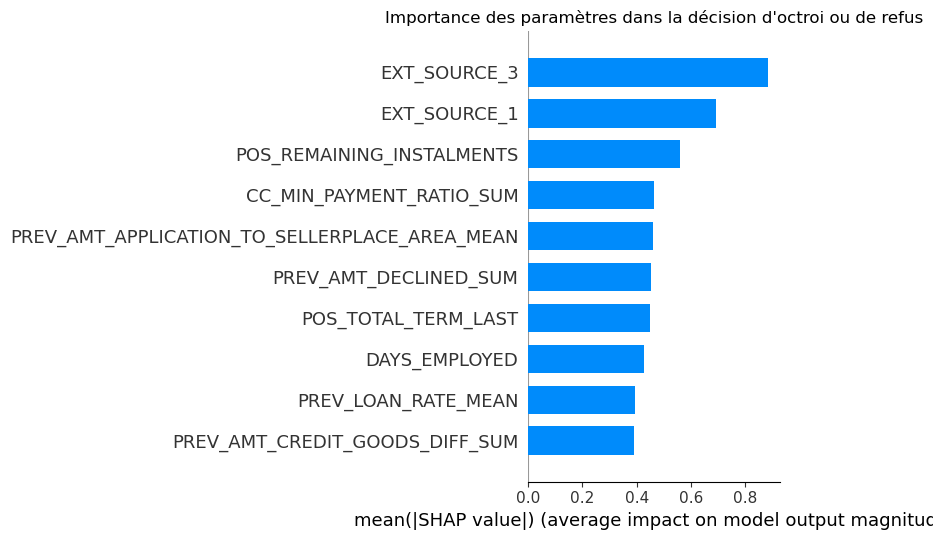

In [308]:
# Summary plot de SHAP
fig, ax = plt.subplots()
plt.title("Importance des paramètres dans la décision d'octroi ou de refus")
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(client_to_explain)  # Calcul des valeurs de SHAP pour le client sélectionné
shap.summary_plot(shap_values, client_to_explain, plot_type="bar",max_display=feat_number, color_bar=False)

## <span style='background: PowderBlue'>6. Déploiement</span>

### <span style='background:orange'>6.1. Signature d'un modèle</span>

Afin de garantir que les données d'entrée d'un modèle sont conformes à ce qui est attendu, les modèles MLflow peuvent inclure des métadonnées décrivant les entrées et sorties :

- **Model Signature** : description des entrées et sorties du modèle
- **Model Input Example** : exemple d'une entrée valide

La signature du modèle permet de renseigner le nom des colonnes et leurs types afin de vérifier s'ils sont similaires lors de la prédientation
)

In [316]:
# Dataset avec valeurs manquantes
X_train_with_na = X_train.copy()

# Convertir toutes les colonnes en type float64
X_train_with_na = X_train_with_na.astype(np.float64)

# Ajouter une ligne avec des valeurs manquantes
X_train_with_na.iloc[0, :] = np.nan

# fonction infer_signature afin d'extraire la signature à partir des données d'entrée et de sortie.
signature = infer_signature(X_train_with_na, y_train)

C:\Users\yanni\anaconda3\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


### <span style='background:orange'>6.2. Sauvegarde du modèle</span>

On vérifie qu'un répertoire correspondant au modèle vient bien d'être généré avec les fichiers qu'il doit contenir :

- **Fichier du modèle** : le modèle lui-même sauvegardé. Le fichier contient le modèle scikit-learn entraîné, prêt à être chargé et utilisé pour faire des prédictions.
- **Métadonnées du modèle** : un fichier MLmodel créé pour stocker les métadonnées du modèle, telles que le nom du modèle, la version, les dépendances Python, les paramètres utilisés lors de l'entraînement du modèle, et d'autres informations importantes sur le modèle. Ce fichier est utilisé par MLflow pour charger et gérer les modèles sauvegardés.
- **Autres fichiers** : contenant les requirements, dépendances, etc.


In [318]:
# Sauvegarde du modèle à l'aide de la fonction save_model en précisant la signature.
new_model_path = 'mlflow_model'

mlflow.sklearn.save_model(my_lgbm_classif, new_model_path, signature=signature)

### MLflow UI

- La Tracking UI vous permet de visualiser, rechercher et comparer les runs, ainsi que de télécharger les artefacts ou les métadonnées des runs pour les analyser dans d'autres outils.

- Lien serveur à appliquer dans le terminal :

  ```sh
  mlflow server --backend-store-uri file:///Users/yanni/OneDrive/Bureau/P7_Modelisation_risque_defaut_credit/mlruns



5000

### Réponse du terminal

Serving on http://127.0.0.1:5000


Cette structure rend les informations plus claires et distinctes, facilitant ainsi leur lecture et compréhension.



### <span style='background:orange'>6.3. Déploiement Heroku</span>

- Création du fichier **requirements.tx** tqui contient les dépendances du projet : :
    - Installer pipreqs : **pip install pipreqs**.
    - Dans le dossier du projet, lancer la commande **pip pipreqs**: cela va créer automatiquement le fichier des dépendences.
- Création du fichier **Procfile** (sans extension ! ) pour spécifier les commandes qui sont à exécuter par Heroku app au démarrage.Ce fichier Procfile doit être situé à la racine du projet pour que Heroku le reconnaisse.
  es.

### <span style='background:orange'>6.4. Analyse du Data Drift avec la librairie Evidently</span>

- L'objectif est de tester l’utilisation de la librairie evidently pour détecter dans le futur du Data Drift en production.
- Evidently est un outil d'analyse et de monitoring des données et des modèles d'apprentissage automatique. Il comprend des outils permettant de générer localement des rapports interactifs sur les données et les modèles.
- L'approche la plus simple pour détecter le Data Drift consiste à utiliser des tests statistiques pour comparer la distribution des caractéristiques des données d'apprentissage à la distribution des caractéristiques pendant l'inférence.
- Les méthodes statistiques les plus courantes pour calculer la différence entre deux distributions sont le test de **Kolmogorov-Smirnov** (test KS), le test du **Khi-deux** et la métrique de **Wasserstein**.
- Le data drift (ou dérive de données) se produit lorsqu'il y a des changements de distribution entre les données utilisées en entrée d’un modèle de ML et les données qui ont été utilisées pour entraîner ce modèle (changements liés à diverses raisons : évolution des tendances, changements dans les comportements, erreurs dans les données d'entrée…). Si les données sur lesquelles le modèle a été entraîné le reflète plus les données en production, le data drift peut impacter la performance du modèle. Il est donc important de surveiller régulièrement les données d'entrée et de ré-entraîner le modèle si nécessaire afin de maintenir sa précision et sa fiabilité au fil du temps.

Nous prendrons comme hypothèse que le dataset “application_train” représente les données pour la modélisation et le dataset “application_test” représente les données de nouveaux clients une fois le modèle en production.

In [26]:
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')

In [28]:
application_train = application_train.drop('TARGET', axis=1)

In [29]:
application_train.shape

(307511, 121)

In [30]:
application_test.shape

(48744, 121)

In [31]:
# Initialiser le rapport de drift de données
report = Report(metrics=[DataDriftPreset()])

In [32]:
# Exécuter le rapport sur les datasets de référence et de test
report.run(reference_data=application_train, current_data=application_test)

In [33]:
# Sauvegarder le rapport en format HTML
report.save_html('data_drift_report.html')

**Avec les données d'entrainement générés par le pré-processing, et les donées test**

In [34]:
fic_sav_train_set_sans = \
    'pickle_files/train_set.pickle'
# Chargement de train_set
with open(fic_sav_train_set_sans, 'rb') as df_appli_train_set_sans:
    train_set = pickle.load(df_appli_train_set_sans)
train_set.shape

(307507, 218)

In [35]:
fic_sav_test_set_sans = \
    'pickle_files/test_set.pickle'
# Chargement de test_set
with open(fic_sav_test_set_sans, 'rb') as df_appli_test_set_sans:
    test_set = pickle.load(df_appli_test_set_sans)
test_set.shape

(48744, 217)

In [36]:
train_set = train_set.drop('TARGET', axis=1)

In [37]:
train_set.shape

(307507, 217)

In [38]:
# Initialiser le rapport de drift de données
report = Report(metrics=[DataDriftPreset()])

In [39]:
# Exécuter le rapport sur les datasets de référence et de test
report.run(reference_data=train_set, current_data=test_set)

In [40]:
# Sauvegarder le rapport en format HTML
report.save_html('data_drift_report_ML.html')